# Test of xgboost  (model 1)
  

In [10]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
#from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

  ### Definition of names for plots and files


In [2]:
date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v4/dfcrossmatches_prioritized_v4.csv'
#detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features20191119.pkl'
#features_file = '../ZTF_data/features_20191017_filtered.pkl'
#non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

features_paps = '../ZTF_data/paps_features_all_with_mean.pkl'
features_wise = '../ZTF_data/WISE_SDSS_data_20191119.csv'

class_output = '../ZTF_classifications/classification_xgboost_unlabelled_set_20191119.csv'

model_first_layer = 'stat_xgboost_model1/xgboost_model1_multiclass_layer_'+date
#model_periodic_layer = 'stat_xgboost_model1/xgboost_model1_periodic_layer_'+date
#model_transient_layer = 'stat_xgboost_model1/xgboost_model1_transient_layer_'+date
#model_stochastic_layer = 'stat_xgboost_model1/xgboost_model1_stochastic_layer_'+date

#conf_matrix_name_first_layer = 'stat_xgboost_model1/confusion_matrix_xgboost_model1_hierarchical_layer_'+date
conf_matrix_name_first_layer = 'stat_xgboost_model1/confusion_matrix_xgboost_model1_multiclass_'+date

feature_importance_name_first_layer = 'stat_xgboost_model1/feature_importance_xgboost_model1_multiclass_layer_'+date
#feature_importance_name_periodic_layer = 'stat_xgboost_model1/feature_importance_xgboost_model1_periodic_layer_'+date
#feature_importance_name_transient_layer = 'stat_xgboost_model1/feature_importance_xgboost_model1_transient_layer_'+date
#feature_importance_name_stochastic_layer = 'stat_xgboost_model1/feature_importance_xgboost_model1_stochastic_layer_'+date

### reading the training set files 

In [3]:
df_feat = pd.read_pickle(features_file)
df_labels = pd.read_csv(labels_file,index_col='oid')
df_wise = pd.read_csv(features_wise,index_col='oid')

df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)



/Users/paula/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


162996


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'





#defining the classes included in the RF model
label_order = ['QSO-I','AGN-I', 'Blazar', 'CV/Nova', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'LPV','RS-CVn','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EBSD/D') | (labels['class_hierachical'] == 'EBC')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'RS-CVn') |  (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN-I') |  (labels['class_hierachical'] == 'QSO-I') | (labels['class_hierachical'] == 'Blazar')  | (labels['class_hierachical'] == 'LPV') , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(162435,)


,class_original,class_hierachical
oid,,
ZTF18aawaqeo,CV/Nova,Stochastic
ZTF18acaxfpa,CV/Nova,Stochastic
ZTF18abxehba,CV/Nova,Stochastic
ZTF18aaxjjwu,CV/Nova,Stochastic
ZTF18abnowur,CV/Nova,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]

wise_drop = ['W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z']

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner').join(df_wise.drop(wise_drop, axis=1))
df = df.replace([np.inf, -np.inf], np.nan)
df_train = df.copy()
df_train = df_train.fillna(-999)
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)


labels = labels.loc[df.index.values]


print(df['g-r_max'].values.size)
df.head()

112101


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_high_2,paps_low_1,paps_low_2,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaact,11.0,0.139977,0.328509,1.0,0.363636,0.0,0.472415,-0.031614,2.395997,0.004443,...,-9.990000e+02,0.004899,-999.000000,322.582369,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-0.067
ZTF17aaaaahl,59.0,0.458348,0.956996,6.0,0.338983,0.0,0.032239,0.532763,3.447957,0.016959,...,8.621973e-07,0.526578,0.000733,229.373142,849.637793,0.983051,0.928571,0.850714,0.500000,0.166
ZTF17aaaaajz,0.0,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,4.450488e-05,-999.000000,0.006368,-999.000000,143.078357,-999.000000,0.022727,0.701429,0.979167,-0.020
ZTF17aaaaaly,10.0,0.110826,0.427705,2.0,0.300000,0.0,0.201831,0.001717,0.055476,0.003597,...,6.387781e-06,0.020307,0.000566,4.144941,88.598544,1.000000,0.954545,0.684286,0.794833,-0.051
ZTF17aaaaasi,113.0,2.734854,1.000000,18.0,0.433628,0.0,0.002209,0.871545,0.226679,0.107707,...,6.273197e-07,0.119522,-0.000414,245.809905,-660.435165,0.539823,0.534351,0.686667,0.902500,0.460


  ### Defining functions to plot the confusion matrix and the feature importance


In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data


In [7]:
Y_original = labels['class_original']#.values

le = LabelEncoder()

Y_original_encoded = le.fit_transform(Y_original)

X_original = df#.columns.values.tolist()



#splitting training set
X_train_original, X_test_original, y_train_original, y_test_original = model_selection.train_test_split(X_original,
Y_original_encoded, test_size=0.2, stratify=Y_original_encoded)

## XGBoost Model

In [15]:
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_original), y_train_original))
print(class_weights)
w_array = np.ones(len(y_train_original), dtype = 'float')

for i in range(len(class_weights)):
    w_array[np.where(y_train_original.astype(int)==i)]=class_weights[i]


print(w_array)
print(len(w_array))

dtrain = xgb.DMatrix(data=X_train_original, label=y_train_original, missing=999.0, weight=w_array)
dtest = xgb.DMatrix(data=X_test_original)


exgb_classifier = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)



ros = RandomUnderSampler(sampling_strategy='all')
N_samplers=20
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_original, y_train_original)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_original.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))

exgb_classifier.fit(df_final_X, y_resampled_final)


#exgb_classifier.fit(X_train_original, y_train_original,sample_weight=w_array)

#pred = exgb_classifier.predict(X_test_original)
#pred_proba = exgb_classifier.predict_proba(X_test_original)

#print(pred_proba)

'''
params = {
    'num_boosting_rounds':500,
    'max_depth': 10,
    #'subsample'=0.8,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': len(label_order),
    'n_jobs': 10
}

bst = xgb.train(params, dtrain)
pred = bst.predict(dtest)


class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_original), y_train_original))
class_weights = class_weights/np.max(class_weights)
w_array = np.ones(len(y_train_original), dtype = 'float')
for i, val in enumerate(y_train_original):
    w_array[i] = class_weights[val-1]

print(w_array)
print(len(w_array))

exgb_classifier = XGBClassifier(**params)
exgb_classifier.fit(X_train_original, y_train_original)#, sample_weight=w_array)

pred = exgb_classifier.predict(y_test_original)
'''

#print(classification_report(y_test_original, pred, target_names=label_order))

[3.2231167337550315, 7.615489130434782, 8.7578125, 11.925531914893616, 10.535714285714286, 1.0189056535175423, 0.27365491651205937, 0.20981507823613088, 27.610837438423644, 0.7710826798734352, 0.23316277715379174, 9.084278768233387, 373.6666666666667, 36.396103896103895, 10.535714285714286, 151.48648648648648]
[0.23316278 0.23316278 0.23316278 ... 3.22311673 0.23316278 0.23316278]
89680
[ 0  0  0 ... 15 15 15]
[(0, 300), (1, 300), (2, 300), (3, 300), (4, 300), (5, 300), (6, 300), (7, 300), (8, 300), (9, 300), (10, 300), (11, 300), (12, 300), (13, 300), (14, 300), (15, 300)]


"\nparams = {\n    'num_boosting_rounds':500,\n    'max_depth': 10,\n    #'subsample'=0.8,\n    'objective': 'multi:softmax',  # error evaluation for multiclass training\n    'num_class': len(label_order),\n    'n_jobs': 10\n}\n\nbst = xgb.train(params, dtrain)\npred = bst.predict(dtest)\n\n\nclass_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train_original), y_train_original))\nclass_weights = class_weights/np.max(class_weights)\nw_array = np.ones(len(y_train_original), dtype = 'float')\nfor i, val in enumerate(y_train_original):\n    w_array[i] = class_weights[val-1]\n\nprint(w_array)\nprint(len(w_array))\n\nexgb_classifier = XGBClassifier(**params)\nexgb_classifier.fit(X_train_original, y_train_original)#, sample_weight=w_array)\n\npred = exgb_classifier.predict(y_test_original)\n"

In [19]:
pred = exgb_classifier.predict(X_test_original)
pred_proba = exgb_classifier.predict_proba(X_test_original)
print(classification_report(y_test_original, pred, target_names=le.classes_))

                precision    recall  f1-score   support

         AGN-I       0.58      0.82      0.68       435
        Blazar       0.35      0.70      0.46       184
       CV/Nova       0.30      0.72      0.42       160
          Ceph       0.17      0.74      0.28       118
          DSCT       0.19      0.82      0.31       133
           EBC       0.33      0.54      0.41      1375
        EBSD/D       0.82      0.51      0.63      5121
           LPV       0.99      0.96      0.97      6679
Periodic-Other       0.04      0.55      0.08        51
         QSO-I       0.96      0.83      0.89      1817
           RRL       0.96      0.79      0.87      6010
        RS-CVn       0.18      0.81      0.30       154
          SLSN       0.17      0.25      0.20         4
          SNII       0.38      0.63      0.48        38
          SNIa       0.81      0.89      0.85       133
         SNIbc       0.14      0.11      0.12         9

      accuracy                           0.76 

[ 7  5  7 ...  7 10 10] [ 7 10  7 ...  7 10 10]
['LPV' 'EBC' 'LPV' ... 'LPV' 'RRL' 'RRL'] ['LPV' 'RRL' 'LPV' ... 'LPV' 'RRL' 'RRL']
[[1505  182  115    4    0    0    1    1    2    1    0    1    0    0
     3    2]
 [  34  355   29    1    2    0    8    2    0    0    0    1    0    3
     0    0]
 [  25   24  128    4    0    0    1    0    1    0    0    0    0    0
     0    1]
 [   0    2    6  115    4    1    0    0    3    0    8   10    1    4
     2    4]
 [   0    0    0    1  118    3   11    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    4    1    4    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    1   10    2   24    1    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    1    0    2    1    0    0    0    0    0    0
     0    0]
 [   4    3   17   66    1    0    0    0 2625 1336  167  106   90   10
   387  309]
 [   0    0    3   19    0    0    0    0  361  746   45   31   34    8
    79   49]
 [   1    0    0  

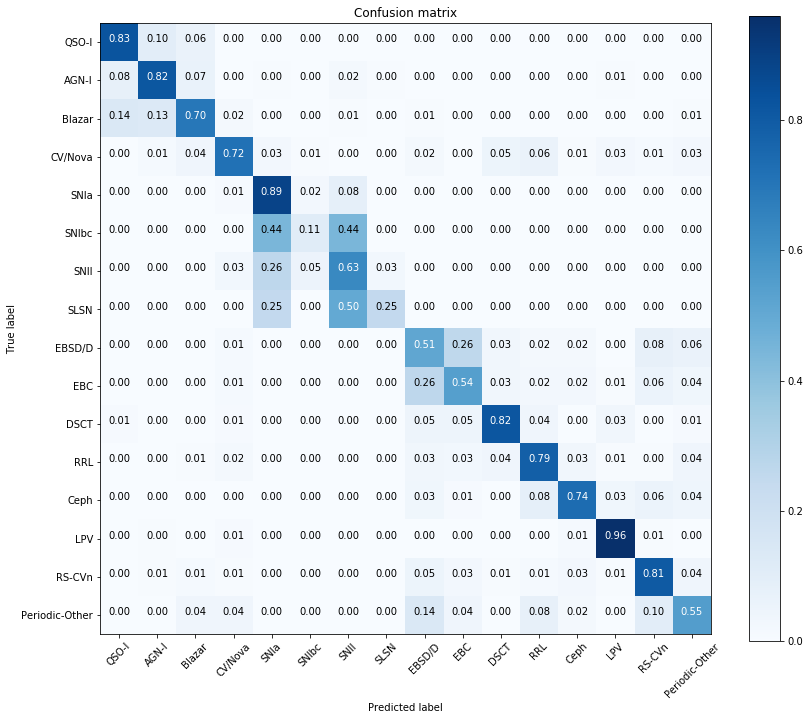

In [20]:
#plotting confusion matrix
print(pred,y_test_original)
y_pred = le.inverse_transform(pred.astype(int))
y_test = le.inverse_transform(y_test_original)
print(y_pred,y_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,conf_matrix_name_first_layer)

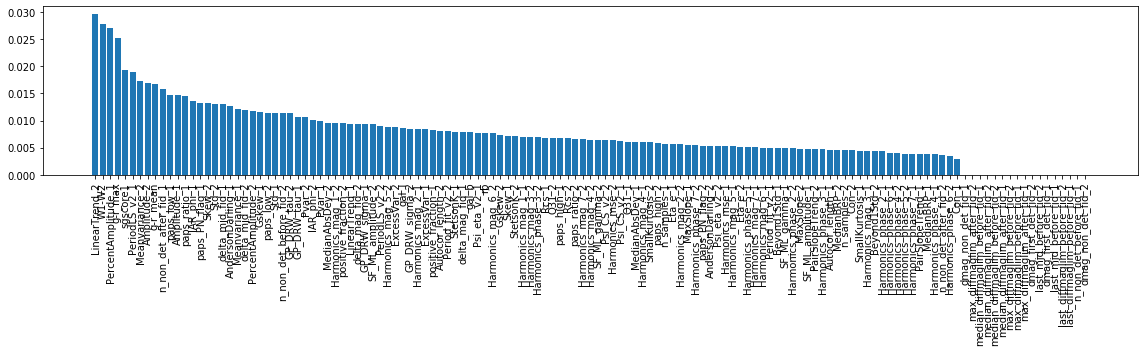

In [21]:
#plotting feature importance
features_list = list(X_train_original)
plot_feature_importances(exgb_classifier, features_list, feature_importance_name_first_layer)

  ## Classifying unlabeled data

In [22]:
#loading the data

print(df_feat.n_samples_1.size)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)

    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()



656546
661828


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_high_2,paps_low_1,paps_low_2,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,0.000019,-999.000000,-0.000028,-999.000000,-1.493229,1.000000,0.500000,0.626905,1.000000,-0.089
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-0.000425,-999.000000,-999.000000,-999.000000,0.083333,0.635476,0.987167,0.038
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,0.000066,0.001623,-0.000195,7.003891,-2.943499,0.459016,0.172414,0.730000,1.000000,-0.160
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,0.000358,0.017857,-0.000073,33.561080,-0.202701,0.156250,0.325581,0.776667,0.999167,0.014
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,0.000210,0.002472,0.003173,1.285452,15.110684,0.844156,0.000000,0.838333,0.996667,0.006


In [23]:
#predicting classes of unlabeled data


test_Y = exgb_classifier.predict(df_feat_ul)
test_Y_proba = exgb_classifier.predict_proba(df_feat_ul)

test_Y_name=le.inverse_transform(test_Y)

In [24]:
#Writing results in the output
df_feat_ul_out = df_feat_ul.copy()

df_out = df_feat_ul_out
print(df_out.shape)


df_out['predicted_class'] = test_Y_name
df_out['predicted_class_proba'] = np.amax(test_Y_proba)
test_data_withclass = df_out

print(np.amax(test_Y_proba))

(661828, 133)
0.9999932


Text(0.5, 1.0, 'sources classified')

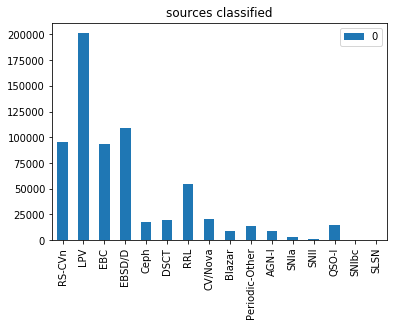

In [25]:
letter_counts = Counter(test_Y_name)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')

In [ ]:
prob_final_class_names_ul = label_order
print(len(prob_final_class_names_ul))
print(prob_final_class_names_ul)

fig, ax = plt.subplots(nrows = len(test_Y_name), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(prob_final_class_names_ul):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

16
['QSO-I', 'AGN-I', 'Blazar', 'CV/Nova', 'SNIa', 'SNIbc', 'SNII', 'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'LPV', 'RS-CVn', 'Periodic-Other']


In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['LPV','QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   print(cl,len(df_test[feature_x][df_test['predicted_class']==cl].values))
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')